In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
import os
try:
  import keras_tuner as kt
except:
  !pip install keras_tuner --upgrade
  os.kill(os.getpid(), 9)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.engine.hypermodel import HyperModel
from keras.utils import plot_model

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Constants
DATA_DIR = 'drive/MyDrive/deep_learning'
INPUT_FILE = 'drive/MyDrive/deep_learning/household_power_consumption.csv'

# Table of Content
- [Problem Description](#scrollTo=IqQF36Bsrqoq)
- [Conclusing Based on Model Comparision](#scrollTo=gsXZLQpEjcrD&line=1&uniqifier=1)
- [Exploratory Data Analysis (EDA)](#scrollTo=N3Gcvf6xFnS3)
- [Time Series Analysis](#scrollTo=IHoMZD3zvHXb)
-[Data Preprocessing](#scrollTo=iRUpyYIdFnS3)
-[Data Preprocessing](#scrollTo=c9z4nNlj0kr7)
-[Build RNN and LSTM Models](#scrollTo=SHfMCWgxFnS3)
-[Evaluate and Compare Models](#scrollTo=z28BoX2SFnS4)
-[Hyperparameter Tuning](#scrollTo=YwFbRubwFnS4)
-[Conclusion and Future Enhancements](#scrollTo=8qsmLyUg565w)
-[References](#scrollTo=aXb2UwTLEET5)

# Problem Description

The goal of this project is to analyze the household electric power consumption data and build predictive models to forecast future electricity usage. The analysis will involve exploring the data, performing time series analysis, and implementing Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) networks to predict future power consumption trends. This project aims to provide insights into electricity usage patterns and develop robust models for accurate forecasting, which can be beneficial for efficient energy management and planning.

In addition to that experiment with the implementation of a morden algorith called NBeatX.  NBeatX is a deep learning model designed for multivariate time series forecasting. It's an extension of the N-BEATS model, which focuses on accurate time series prediction using a stack of fully connected layers.  This is to test how well NBeatX helps in this problem compared to RNN and LSTM.

The data for this project is taken from UC Irvine Machine LearningRepository. [Individual Household Electric Power Consumption](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption)

## Why I am choosing this problem

Throughout this course, we have explored various advanced topics in machine learning and artificial intelligence, including Neural Networks, Gradient Descent, RNN, CNN, GAN, Transformers, and NLP. As the course approaches its conclusion, I aim to focus on Time Series analysis—a critical and ubiquitous problem in the industry due to its sequential nature.

Time Series data presents unique challenges to deep learning models, often resulting in traditional statistical methods outperforming deep learning approaches. To delve into these challenges and explore potential solutions, I have chosen the household electric power consumption dataset from UC Irvine ML Repository. This dataset provides a real-world example for applying Time Series analysis principles and testing deep learning models.

By tackling this problem, I intend to gain deeper insights into the intricacies of Time Series data, enhance my understanding of how to effectively apply deep learning techniques in this context, and compare their performance against traditional statistical frameworks. This project not only consolidates my learning from the course but also equips me with practical skills highly relevant to industry applications.

## Project Plan:

1. Data Exploration and Preprocessing:
   - Load the dataset and inspect the structure and content.
   - Handle missing values, if any.
   - Convert the date and time information to a suitable datetime format.
   - Resample the data to a suitable frequency (e.g., hourly, daily) based on the analysis requirements.
   - Perform exploratory data analysis (EDA) to understand the distribution and patterns in the data.

2. Time Series Analysis:
   - Decompose the time series to identify trends, seasonality, and residual components.
   - Visualize the time series components to gain insights into the underlying patterns.
   - Perform stationarity tests (e.g., ADF test) and apply differencing if necessary to make the series stationary.

3. Modeling with RNN and LSTM:
   - Split the data into training and testing sets.
   - Normalize the data for better model performance.
   - Build and train RNN and LSTM models using the prepared features.
   - Tune the hyperparameters of the models for optimal performance.
   - Evaluate the models using appropriate metrics (e.g., RMSE, MAE) on the test set.

4. Model Evaluation and Comparison:
   - Compare the performance of RNN and LSTM models.
   - Analyze the forecasted results and compare them with actual values.
   - Visualize the predictions to assess the model's accuracy and reliability.

# Data Description

| **Column**               | **Description**                                                                                                          |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------|
| Date                     | Date in format dd/mm/yyyy                                                                                                |
| Time                     | Time in format hh:mm:ss                                                                                                   |
| Global_active_power      | Household global minute-averaged active power (in kilowatt)                                                              |
| Global_reactive_power    | Household global minute-averaged reactive power (in kilowatt)                                                            |
| Voltage                  | Minute-averaged voltage (in volt)                                                                                        |
| Global_intensity         | Household global minute-averaged current intensity (in ampere)                                                           |
| Sub_metering_1           | Energy sub-metering No. 1 (in watt-hour of active energy). <br>It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). |
| Sub_metering_2           | Energy sub-metering No. 2 (in watt-hour of active energy).<br> It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. |
| Sub_metering_3           | Energy sub-metering No. 3 (in watt-hour of active energy).<br> It corresponds to an electric water-heater and an air-conditioner.                                |


# Loading and Preprocessing

In [ ]:
# Load data
df = pd.read_csv(INPUT_FILE, sep=';', low_memory=False, na_values=['nan','?'])

# Drop rows with missing values
df.dropna(inplace=True)

# Convert data types
df = df.astype({
    'Global_active_power': 'float32',
    'Global_reactive_power': 'float32',
    'Voltage': 'float32',
    'Global_intensity': 'float32',
    'Sub_metering_1': 'float32',
    'Sub_metering_2': 'float32',
    'Sub_metering_3': 'float32'
})

In [ ]:
# Creating Datatime
df['Datetime'] = df['Date'] + ' ' + df['Time']

df['Datetime'] = pd.to_datetime(df.Datetime, format='%d/%m/%Y %H:%M:%S')

df.drop(['Date', 'Time'], axis=1, inplace=True)

# Set Datetime as index
df.set_index('Datetime', inplace=True)

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


In [ ]:
df.shape

(2049280, 7)

# Exploratory Data Analysis (EDA)

## Plot Timeseries

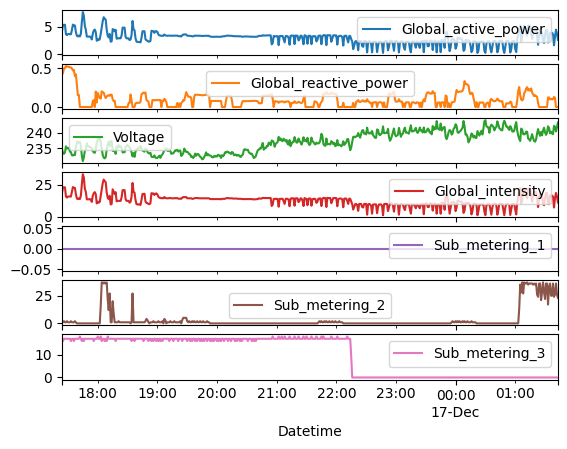

In [ ]:
plot_cols = df.columns
# Sample plot with window for first 500 records
plot_features = df[plot_cols][:500]
_ = plot_features.plot(subplots=True)

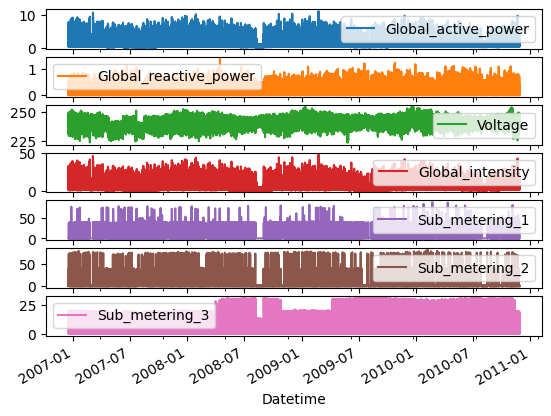

In [ ]:
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

## Correlation Matrix

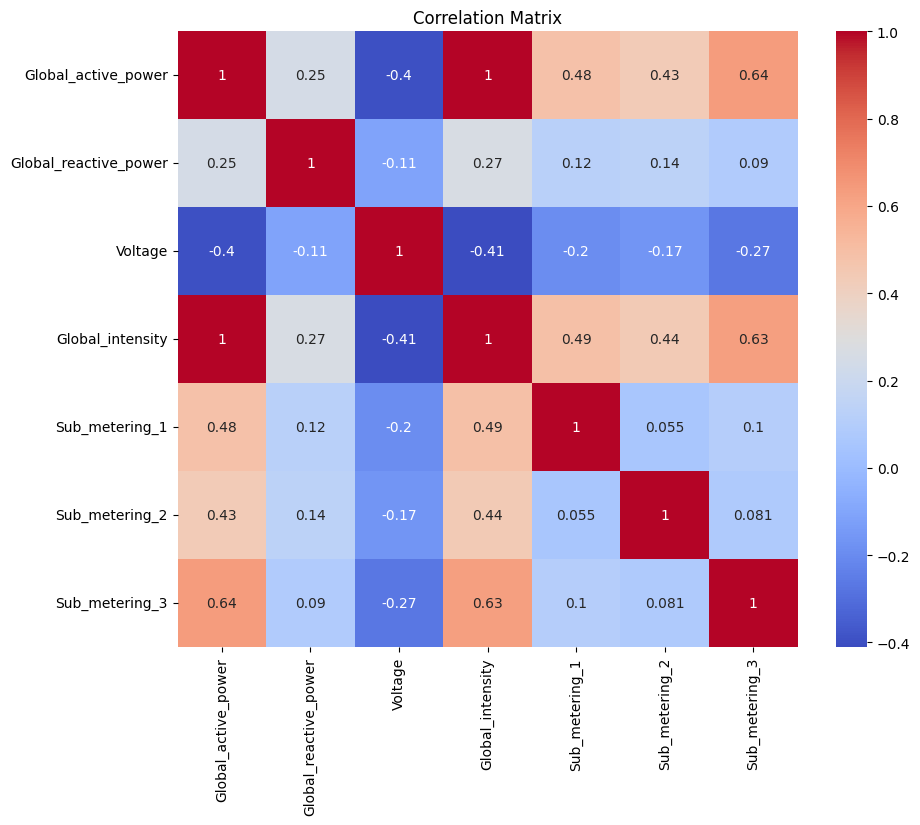

In [ ]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The correlation matrix provides insights into the relationships between the different features:

1. `Global_active_power` has a strong positive correlation with `Global_intensity` (correlation coefficient = 1) and a moderate positive correlation with `Sub_metering_3` (0.64).
2. `Voltage` has a moderate negative correlation with both `Global_active_power` (-0.4) and `Global_intensity` (-0.41), indicating that as voltage increases, both power and intensity tend to decrease.
3. `Sub_metering_1, 2,` and `3` show moderate positive correlations with `Global_active_power`, with `Sub_metering_3` having the strongest correlation (0.64).
4. `Global_reactive_power` shows a weak positive correlation with other variables, indicating a relatively independent behavior compared to other features.
5. `Global_intensity` correlates strongly with `Global_active_power` (1) and moderately with `Sub_metering_3` (0.63), suggesting a link between power consumption and the intensity of electrical usage.

In time series data, instead of using a traditional correlation matrix, you can use several alternative methods to understand the relationships between different time series. Here are a few common techniques:

1. Cross-Correlation Function (CCF)
2. Partial Autocorrelation Function (PACF)
3. Granger Causality Test
4. Dynamic Time Warping (DTW)
5. Vector Autoregression (VAR)
6. Mutual Information

## Distribution Plot

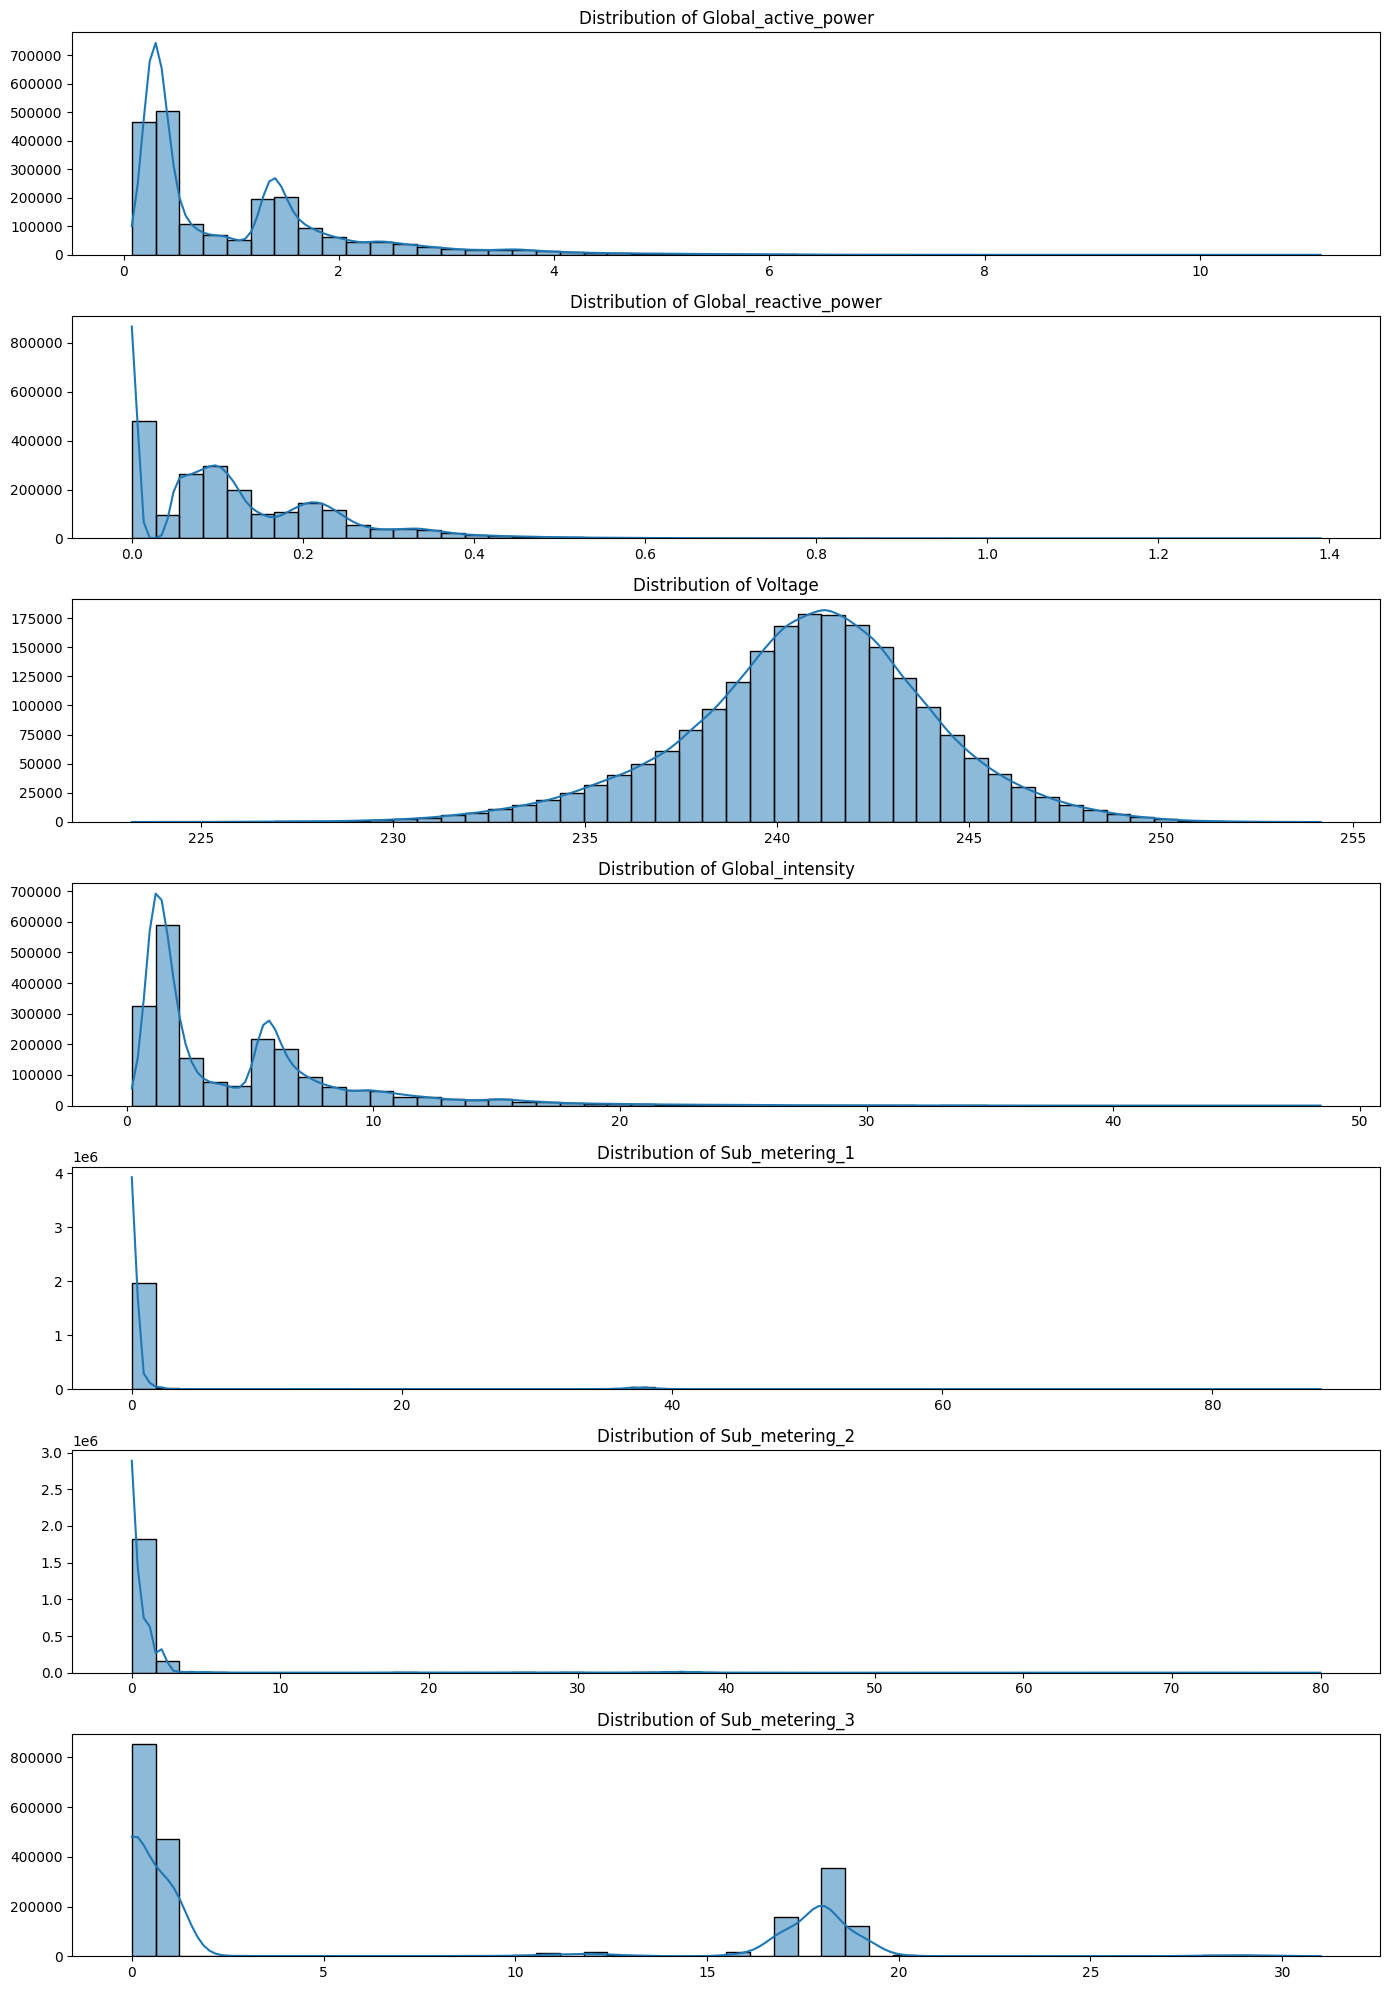

In [ ]:
# Distribution Plot of all variables
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

plt.figure(figsize=(14, 20))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i + 1)
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

### Distribution Plot Observations

1. `Global_active_power`:
   - Distribution is right-skewed with a peak around 0.5 to 1 kW.
   - Majority of the data falls below 2 kW.
   - There are some outliers with values greater than 4 kW.

2. `Global_reactive_power`:
   - Distribution is highly right-skewed, peaking near 0.0 kW.
   - Most values are concentrated below 0.2 kW.
   - There are a few outliers with values up to 1.4 kW.

3. `Voltage`:
   - Distribution appears to be approximately normal.
   - Centered around 240 volts with most values between 235 and 245 volts.
   - Indicates a stable voltage supply with minor variations.

4. `Global_intensity`:
   - Distribution is right-skewed with a peak around 0 to 10 amperes.
   - Majority of the data falls below 20 amperes.
   - There are some outliers with values up to 50 amperes.

5. `Sub_metering_1`:
   - Distribution is highly right-skewed with a peak near 0.
   - Most values are concentrated below 2.
   - Few data points exceed 10, with some extreme outliers.

6. `Sub_metering_2`:
   - Similar to Sub_metering_1, the distribution is highly right-skewed.
   - Peak is near 0, with most values below 5.
   - Some outliers extend up to 50.

7. `Sub_metering_3`:
   - Distribution shows two peaks, one near 0 and another around 18.
   - Most values are concentrated near these peaks.
   - A few outliers are present, extending up to 30.

Almost all features exhibit right-skewed distributions except for Voltage, which is approximately normally distributed. This indicates that values for active and reactive power, global intensity, and sub-meterings are generally low with few high outliers, whereas Voltage remains relatively stable around its mean value.

## Summary Statistics

Overall, the data suggests that there is considerable variability in power usage, particularly in the active power and current. The voltage supply appears stable, and the sub-metering data indicate different usage patterns for different appliances.

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076000,0.308000,0.602000,1.528000,11.122000
Global_reactive_power,2049280.0,0.123714,0.112722,0.000000,0.048000,0.100000,0.194000,1.390000
Voltage,2049280.0,240.839813,3.239987,223.199997,238.990005,241.009995,242.889999,254.149994
Global_intensity,2049280.0,4.627758,4.444396,0.200000,1.400000,2.600000,6.400000,48.400002
Sub_metering_1,2049280.0,1.121923,6.153031,0.000000,0.000000,0.000000,0.000000,88.000000
Sub_metering_2,2049280.0,1.298520,5.822026,0.000000,0.000000,0.000000,1.000000,80.000000
Sub_metering_3,2049280.0,6.458447,8.437154,0.000000,0.000000,1.000000,17.000000,31.000000


## Resample Data to Hourly Frequency

The dataset provided contains minute-level data. For this analysis, we will aggregate the data to an hourly frequency.

Choosing the correct frequency in time series analysis is crucial for several reasons:
1. Capturing Patterns and Seasonality
2. Model Accuracy
3. Data Granularity
4. Resource Efficiency
5. Business Relevance.

In [ ]:
# Define the aggregation functions for each column
aggregation_functions = {
    'Global_active_power': 'sum',        # You might want to sum power consumption
    'Global_reactive_power': 'sum',      # Sum reactive power
    'Voltage': 'mean',                   # Average voltage
    'Global_intensity': 'mean',          # Average intensity
    'Sub_metering_1': 'sum',             # Sum of sub metering
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
}

# Resample the data to hourly frequency and apply the aggregation functions
df_hourly = df.resample('H').aggregate(aggregation_functions)

# Print the first few rows of the resampled data
df_hourly.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:00:00,152.024002,8.243999,234.643875,18.099998,0.0,19.0,607.0
2006-12-16 18:00:00,217.932007,4.802000,234.580154,15.600000,0.0,403.0,1012.0
2006-12-16 19:00:00,204.013992,5.114000,233.232498,14.503333,0.0,86.0,1001.0
2006-12-16 20:00:00,196.113998,4.506000,234.071503,13.916667,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388000,4.600000,237.158661,13.046666,0.0,25.0,1033.0


In [ ]:
df.shape, df_hourly.shape

((2049280, 7), (34589, 7))

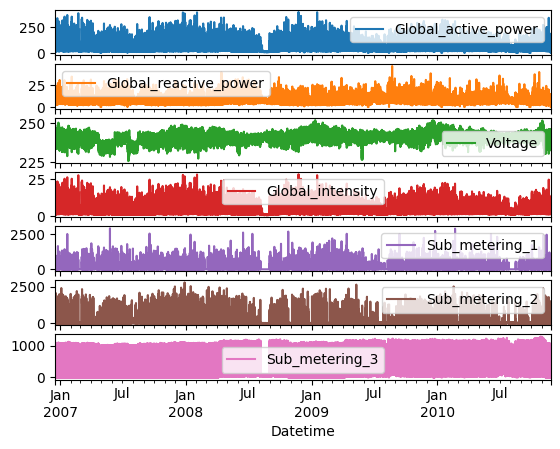

In [ ]:
plot_cols = df_hourly.columns

# Sample plot with window for first 500 records
plot_features = df_hourly[plot_cols]
_ = plot_features.plot(subplots=True)

In [ ]:
df_hourly.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34589.0,64.674454,53.995514,0.000000,20.218000,46.948002,94.206001,393.631989
Global_reactive_power,34589.0,7.329660,4.066807,0.000000,4.618000,6.364000,8.920000,46.459999
Voltage,34168.0,240.839401,3.001093,225.834503,239.180664,240.977844,242.695007,251.902008
Global_intensity,34168.0,4.628238,3.757797,0.503333,1.513333,3.423333,6.606667,28.383333
Sub_metering_1,34589.0,66.470123,211.089859,0.000000,0.000000,0.000000,0.000000,2902.000000
Sub_metering_2,34589.0,76.932869,250.148941,0.000000,0.000000,19.000000,39.000000,2786.000000
Sub_metering_3,34589.0,382.640930,440.306793,0.000000,38.000000,99.000000,837.000000,1293.000000


`Global_active_power` and `Global_reactive_power` have a skewed distribution with most values concentrated at the lower end.

`Voltage` is normally distributed, centered around 240 volts.

`Global_intensity` shows a right-skewed distribution with most values below 10 amperes.

`Sub_metering_1`, `Sub_metering_2`, and `Sub_metering_3` have many zero values, indicating a lot of instances where there is no sub-metering usage recorded. The mean values are relatively low with high standard deviations, showing a few high outliers.

# Time Series Analysis


## Time Series Decomposition

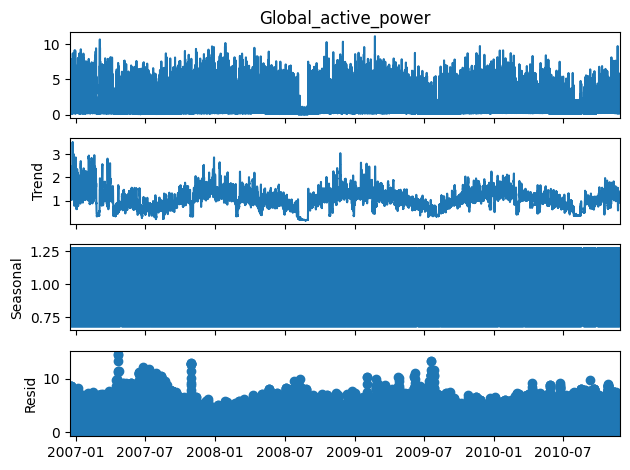

In [ ]:
# Decompose the time series
result = seasonal_decompose(df['Global_active_power'], model='multiplicative', period=24*60)  # Assuming daily seasonality

# Plot decomposition
result.plot()
plt.show()

Time series decomposition is typically applied to the target variable in time series forecasting. The primary goal of decomposition is to separate the time series into its underlying components: trend, seasonality, and residuals (noise). This helps in understanding the underlying patterns in the target variable, which can improve model performance and interpretability.

### Why Focus on the Target Variable?
#### Understanding Patterns:
Decomposition helps to understand the trend, seasonal, and irregular components of the target variable. This is crucial for making accurate predictions.

#### Modeling Seasonality and Trend:
Identifying seasonality and trend in the target variable can help in creating features that improve model performance.

#### Residual Analysis:
Analyzing the residual component can help identify any anomalies or irregular patterns that might need to be addressed separately.

### Original Series (Global_active_power):
This plot shows the raw time series data for global active power. The data appears to have a lot of variability and some visible peaks and troughs over time.

### Trend Component:
The trend component shows the long-term progression of the series. It reveals the underlying direction in the data over a longer period, ignoring the short-term fluctuations. In your plot, the trend indicates that there is some fluctuation over time, but it seems to be relatively stable with periodic rises and falls.

### Seasonal Component:
The seasonal component captures the repeating short-term cycles in the series. This component should typically show a pattern that repeats at a regular interval (e.g., daily, weekly, yearly). However, in your plot, the seasonal component appears flat, which could imply that either the seasonal pattern is not significant in this data, or the decomposition parameters need adjustment (e.g., the period might be incorrectly specified).

### Residual Component (Resid):
The residual component is what remains after removing the trend and seasonal components from the original series. It represents the irregular, random noise in the data. Your residual plot shows some variability, with some significant spikes, indicating periods of irregularities that aren't captured by the trend or seasonal components.

## Stationarity Tests And Correction

Performing a stationarity test is a good idea to better understand the properties of your time series data. Stationarity implies that the statistical properties of the time series (such as mean, variance, and autocorrelation) are constant over time. Many time series models, including ARIMA and many forms of neural networks, assume that the data is stationary.

#### Common Stationarity Tests:
- Augmented Dickey-Fuller (ADF) Test
- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
- Phillips-Perron (PP) Test

While traditional time series models like ARIMA require stationarity, deep learning models such as RNNs and LSTMs do not strictly require the data to be stationary. These models can learn complex patterns and dependencies in non-stationary data due to their flexible architectures. However, preprocessing steps such as scaling and normalization are still important to ensure effective training.

Here are some considerations:

#### When to Perform Stationarity Correction:
- Traditional Models: If you plan to use traditional statistical models like ARIMA, SARIMA, or exponential smoothing, you should perform stationarity correction.
- Hybrid Models: If you are combining deep learning with traditional methods or if stationarity correction helps improve model performance and convergence.
#### When Not Necessary:
- Deep Learning Models: For RNNs, LSTMs, and other neural networks, it's not strictly necessary to make the data stationary. These models can handle non-stationary data well, especially with proper scaling and normalization.
- Complex Patterns: Deep learning models can learn and adapt to complex patterns, trends, and seasonality without requiring the data to be stationary.

# Data Preprocessing

In [ ]:
print(df_hourly.isnull().sum())

Global_active_power        0
Global_reactive_power      0
Voltage                  421
Global_intensity         421
Sub_metering_1             0
Sub_metering_2             0
Sub_metering_3             0
dtype: int64


In [ ]:
# Fill missing values using forward fill method
df_hourly.fillna(method='ffill', inplace=True)

In [ ]:
print(df_hourly.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


# Feature Selection
## Dropping out Sub_metering_x
The inclusion of Sub_metering_1, Sub_metering_2 and Sub_metering_3 create invalid loss value calculation due to large number of zeros, for now we try without this values for the model.

In [ ]:
# Calculate the number of zero and non-zero values
sub_metering_1_zeros = df_hourly['Sub_metering_1'].eq(0).sum()
sub_metering_1_non_zeros = len(df_hourly['Sub_metering_1']) - sub_metering_1_zeros

sub_metering_2_zeros = df_hourly['Sub_metering_2'].eq(0).sum()
sub_metering_2_non_zeros = len(df_hourly['Sub_metering_2']) - sub_metering_2_zeros

sub_metering_3_zeros = df_hourly['Sub_metering_3'].eq(0).sum()
sub_metering_3_non_zeros = len(df_hourly['Sub_metering_3']) - sub_metering_3_zeros

print(f"Sub_metering_1: {sub_metering_1_zeros} zeros, {sub_metering_1_non_zeros} non-zeros")
print(f"Sub_metering_2: {sub_metering_2_zeros} zeros, {sub_metering_2_non_zeros} non-zeros")
print(f"Sub_metering_3: {sub_metering_3_zeros} zeros, {sub_metering_3_non_zeros} non-zeros")

Sub_metering_1: 29652 zeros, 4937 non-zeros
Sub_metering_2: 10780 zeros, 23809 non-zeros
Sub_metering_3: 8351 zeros, 26238 non-zeros


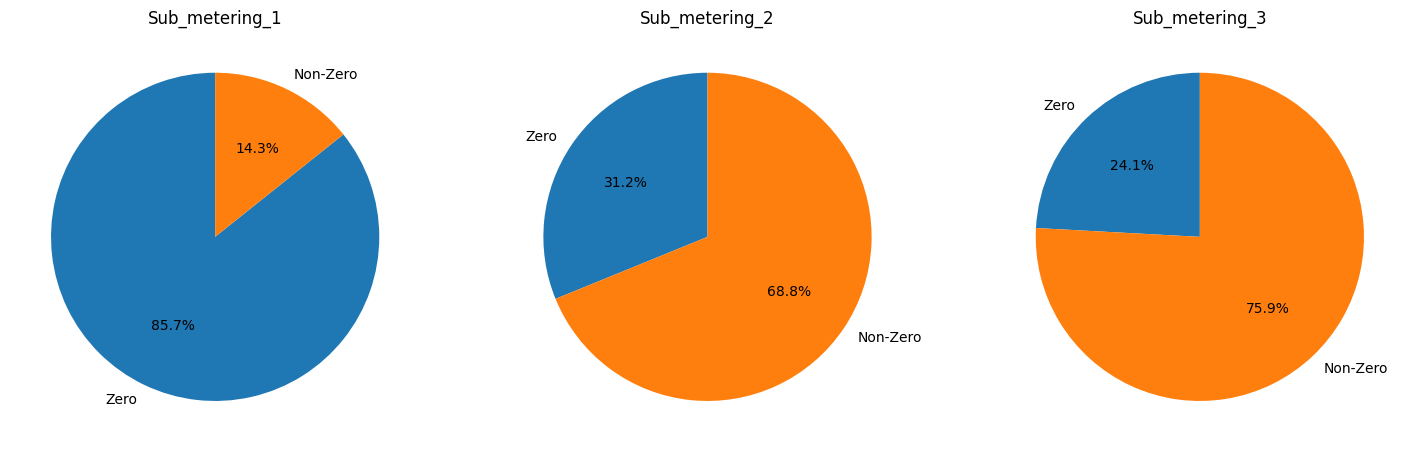

In [ ]:
# Create pie chart for Sub_metering_1, Sub_metering_2 and Sub_metering_3
# Ploting total zeros against not zero values
labels = ['Zero', 'Non-Zero']

sub_metering_1_data = [sub_metering_1_zeros, sub_metering_1_non_zeros]
sub_metering_2_data = [sub_metering_2_zeros, sub_metering_2_non_zeros]
sub_metering_3_data = [sub_metering_3_zeros, sub_metering_3_non_zeros]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].pie(sub_metering_1_data, labels=labels, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Sub_metering_1')

axs[1].pie(sub_metering_2_data, labels=labels, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Sub_metering_2')

axs[2].pie(sub_metering_3_data, labels=labels, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Sub_metering_3')

plt.show()

In [ ]:
# Feature selection
features = df_hourly[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']]
target = df_hourly['Global_active_power']


In [ ]:
features.head(), features.shape

(                     Global_active_power  Global_reactive_power     Voltage  \
 Datetime                                                                      
 2006-12-16 17:00:00           152.024002               8.243999  234.643875   
 2006-12-16 18:00:00           217.932007               4.802000  234.580154   
 2006-12-16 19:00:00           204.013992               5.114000  233.232498   
 2006-12-16 20:00:00           196.113998               4.506000  234.071503   
 2006-12-16 21:00:00           183.388000               4.600000  237.158661   
 
                      Global_intensity  
 Datetime                               
 2006-12-16 17:00:00         18.099998  
 2006-12-16 18:00:00         15.600000  
 2006-12-16 19:00:00         14.503333  
 2006-12-16 20:00:00         13.916667  
 2006-12-16 21:00:00         13.046666  ,
 (34589, 4))

In [ ]:
target.head()

Datetime
2006-12-16 17:00:00    152.024002
2006-12-16 18:00:00    217.932007
2006-12-16 19:00:00    204.013992
2006-12-16 20:00:00    196.113998
2006-12-16 21:00:00    183.388000
Freq: H, Name: Global_active_power, dtype: float32

In [ ]:
hourly_mean = features.mean()
hourly_std = features.std()
df_std = (features - hourly_mean) / hourly_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

<ipython-input-25-fefe3fc2d474>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(df.keys(), rotation=90)


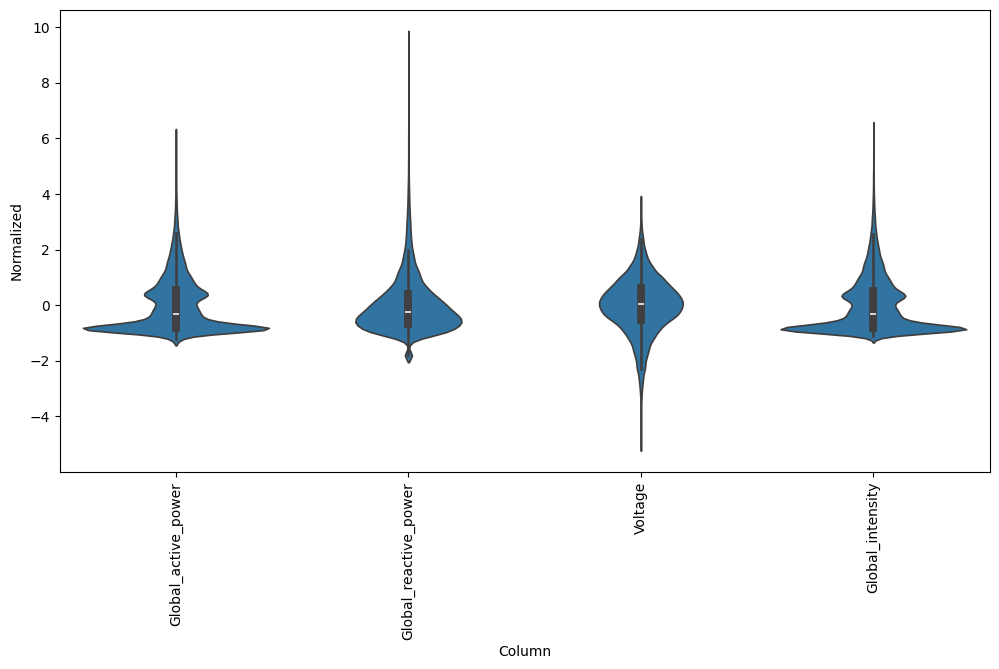

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Violin plots are a powerful way to visualize the distribution and variability of your data. From these plots, you can infer that:

Power consumption and intensity have moderate variability.
Voltage is quite stable.
Sub_metering measurements often have low values with occasional spikes.
These insights can help guide further analysis and model building by understanding the nature and distribution of your data.

In [ ]:
# Normalize data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
target = target.values.reshape(-1, 1)
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target)

In [ ]:
# Create sequences for time series forecasting
def create_sequences(data, target, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 8
X, y = create_sequences(scaled_features, scaled_target, seq_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X), len(y)

(34581, 34581)

# Build RNN and LSTM Models

### Summary of RNN Architecture

![RNN Architecture](https://www.researchgate.net/publication/349025949/figure/fig5/AS:987328210284547@1612408797977/A-simple-RNN-architecture-unrolling.ppm)

RNNs are a class of neural networks designed for processing sequential data. Unlike traditional feedforward neural networks, RNNs have connections that form directed cycles, allowing information to persist. This feature makes RNNs particularly well-suited for tasks where the order of the data is important, such as time series forecasting, language modeling, and sequence generation.

#### Key Components of RNN Architecture:
1. **Input Layer**: Accepts the input sequence data.
2. **Recurrent Layer**: Contains units that maintain hidden states over time. At each time step, the current input and the previous hidden state are used to compute the current hidden state.
3. **Output Layer**: Produces the output for each time step or the final output, depending on the specific task.

### Summary of LSTM Architecture

![LSTM Architecture](https://www.researchgate.net/publication/344213150/figure/fig1/AS:956842494660610@1605140436435/A-typical-architecture-of-a-long-short-term-memory-LSTM-cell-An-LSTM-block-typically.ppm)

Long Short-Term Memory (LSTM)networks are a special kind of RNN capable of learning long-term dependencies. They were introduced to mitigate the vanishing gradient problem that standard RNNs face, making them better at capturing long-range dependencies in sequential data.

#### Key Components of LSTM Architecture:
1. **Input Layer**: Accepts the input sequence data.
2. **LSTM Units**: Each LSTM unit contains a cell state and three types of gates (input gate, forget gate, and output gate) that regulate the flow of information:
   - **Input Gate**: Controls how much of the new information from the input flows into the cell state.
   - **Forget Gate**: Determines what information from the cell state should be discarded.
   - **Output Gate**: Controls how much of the information in the cell state should be output at the current time step.
3. **Output Layer**: Produces the output for each time step or the final output, depending on the specific task.

### Comparison between RNN and LSTM

| Feature                  | RNN                              | LSTM                                      |
|--------------------------|----------------------------------|-------------------------------------------|
| **Architecture**         | Simple recurrent structure       | Complex units with gates                  |
| **Capability**           | Captures short-term dependencies | Captures long-term dependencies           |
| **Gradient Issues**      | Prone to vanishing/exploding     | Mitigates vanishing gradient problem      |
| **Computational Cost**   | Lower                            | Higher due to complex gates               |
| **Training Stability**   | Less stable for long sequences   | More stable for long sequences            |
| **Use Cases**            | Simple sequential tasks          | Tasks requiring long-term memory retention|

### Description of Implemented RNN and LSTM

#### RNN Implementation:
In the provided implementation, a simple RNN architecture is used. The model consists of:
1. `SimpleRNN Layer`: This layer processes the input sequences and maintains hidden states over time steps. It uses the ReLU activation function.
2. `Dense Layer`: This is a fully connected layer that produces the final output.

#### LSTM Implementation:
In the provided implementation, an LSTM architecture is used. The model consists of:
1. `LSTM Layer`: This layer processes the input sequences and maintains cell states and hidden states over time steps. It uses the ReLU activation function.
2. `Dense Layer`: This is a fully connected layer that produces the final output.

### Hyperparameter Tuning with Keras Tuner

Both models were optimized using Keras Tuner with Random Search. The hyperparameters tuned include the number of units in the recurrent layers and the learning rate.

Both RNN and LSTM architectures are powerful for sequential data tasks. RNNs are simpler and computationally less expensive but struggle with long-term dependencies. LSTMs, with their gating mechanisms, effectively handle long-term dependencies and are more stable for longer sequences, albeit at a higher computational cost. The provided implementations demonstrate how to set up and tune these models for time series forecasting using Keras Tuner.

In [ ]:
# Build RNN model
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [ ]:
# Build LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [ ]:
# Train and evaluate models
input_shape = (X_train.shape[1], X_train.shape[2])
input_shape

(8, 4)

In [ ]:
# RNN
rnn_model = build_rnn_model(input_shape)
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2750      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2801 (10.94 KB)
Trainable params: 2801 (10.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


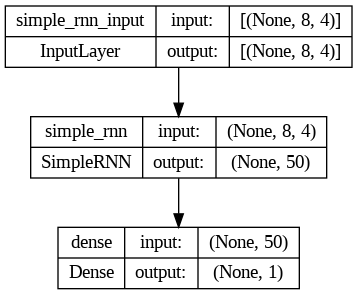

In [ ]:
plot_model(rnn_model, to_file='model_plot_RNN.png', show_shapes=True, show_layer_names=True)

In [ ]:
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

Epoch 1/25
865/865 [==============================] - 8s 6ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 2/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0085 - val_loss: 0.0088
Epoch 3/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 4/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 5/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0082 - val_loss: 0.0086
Epoch 6/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0081 - val_loss: 0.0084
Epoch 7/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0081 - val_loss: 0.0085
Epoch 8/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 9/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0080 - val_loss: 0.0082
Epoch 10/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0079 - val_loss: 0.0083

In [ ]:
# LSTM
lstm_model = build_lstm_model(input_shape)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11051 (43.17 KB)
Trainable params: 11051 (43.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


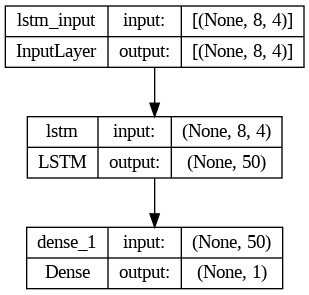

In [ ]:
plot_model(lstm_model, to_file='model_plot_RNN.png', show_shapes=True, show_layer_names=True)

In [ ]:
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=10, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

Epoch 1/25
2767/2767 [==============================] - 25s 8ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 2/25
2767/2767 [==============================] - 23s 8ms/step - loss: 0.0084 - val_loss: 0.0088
Epoch 3/25
2767/2767 [==============================] - 23s 8ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 4/25
2767/2767 [==============================] - 23s 8ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 5/25
2767/2767 [==============================] - 23s 8ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 6/25
2767/2767 [==============================] - 23s 8ms/step - loss: 0.0081 - val_loss: 0.0084
Epoch 7/25
2767/2767 [==============================] - 23s 8ms/step - loss: 0.0081 - val_loss: 0.0085
Epoch 8/25
2767/2767 [==============================] - 23s 8ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 9/25
2767/2767 [==============================] - 23s 8ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 10/25
2767/2767 [==============================] - 23s 8ms/step - l

# Evaluate and Compare Models

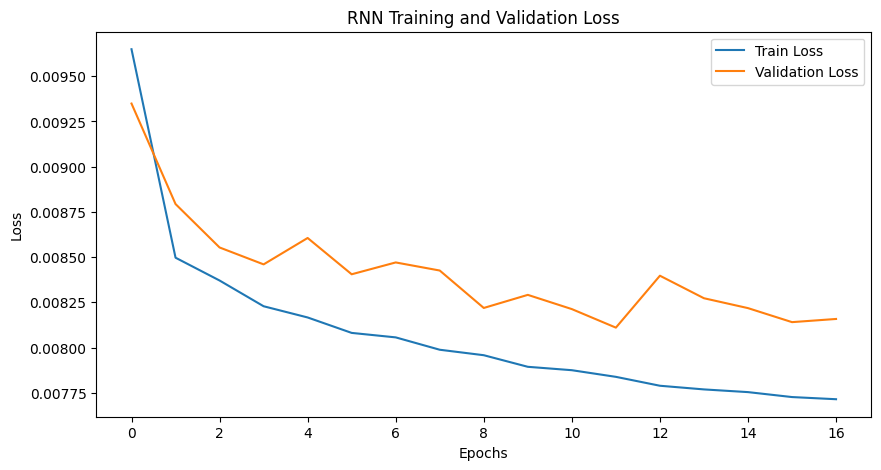

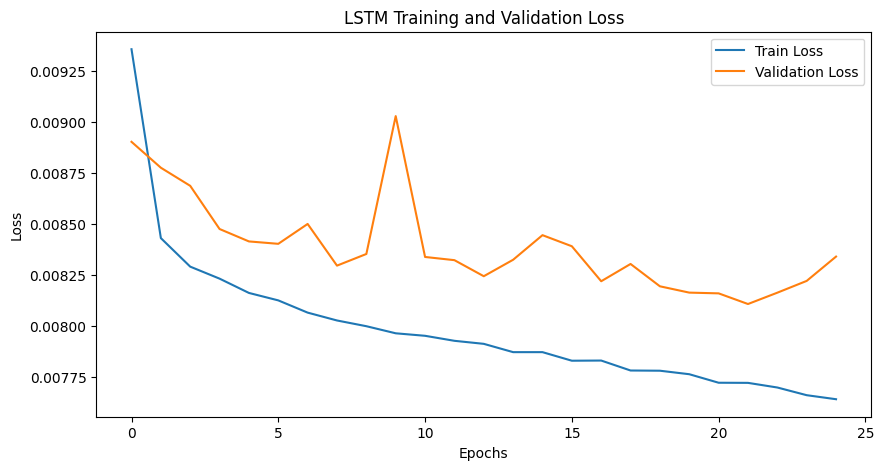

In [ ]:
# Plot training and validation loss
def plot_history(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(rnn_history, 'RNN Training and Validation Loss')
plot_history(lstm_history, 'LSTM Training and Validation Loss')

In [ ]:
# Predict and evaluate
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = np.mean((predictions - y_test) ** 2)
    return mse, predictions

rnn_mse, rnn_predictions = evaluate_model(rnn_model, X_test, y_test)
lstm_mse, lstm_predictions = evaluate_model(lstm_model, X_test, y_test)

print(f'RNN MSE: {rnn_mse}')
print(f'LSTM MSE: {lstm_mse}')

217/217 [==============================] - 1s 3ms/step
RNN MSE: 0.008158200420439243
LSTM MSE: 0.008340290747582912


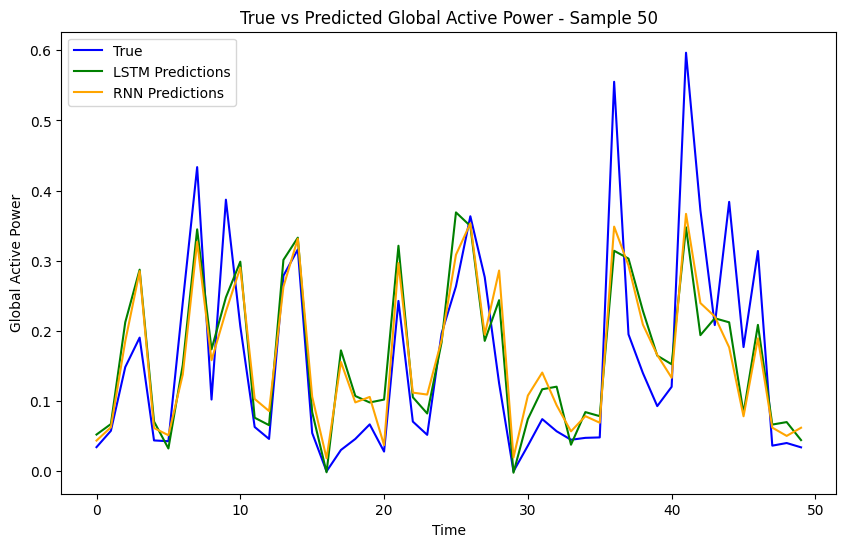

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each series on the same axis
ax.plot(y_test[:50], color='blue', label='True')
ax.plot(lstm_predictions[:50], color='green', label='LSTM Predictions')
ax.plot(rnn_predictions[:50], color='orange', label='RNN Predictions')

# Add title and labels
ax.set_title('True vs Predicted Global Active Power - Sample 50')
ax.set_xlabel('Time')
ax.set_ylabel('Global Active Power')

# Add a legend
ax.legend()

# Display the plot
plt.show()

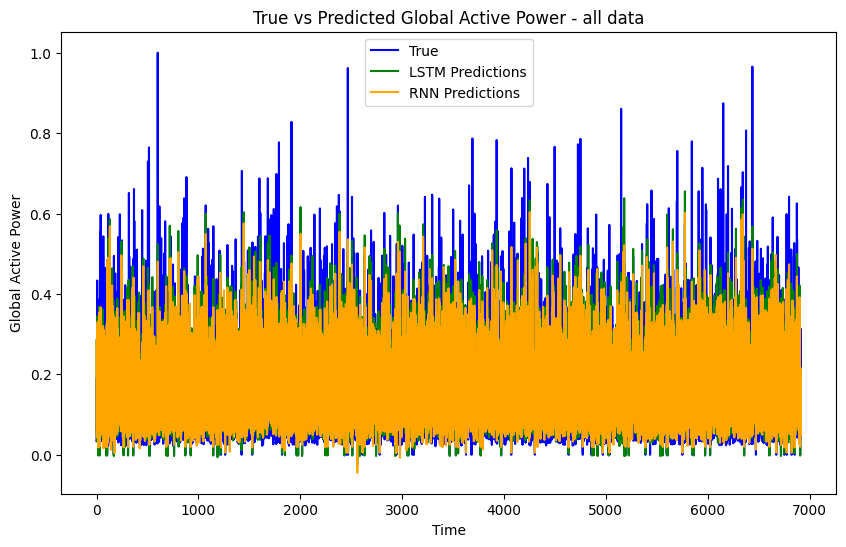

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each series on the same axis
ax.plot(y_test, color='blue', label='True')
ax.plot(lstm_predictions, color='green', label='LSTM Predictions')
ax.plot(rnn_predictions, color='orange', label='RNN Predictions')

# Add title and labels
ax.set_title('True vs Predicted Global Active Power - all data')
ax.set_xlabel('Time')
ax.set_ylabel('Global Active Power')

# Add a legend
ax.legend()

# Display the plot
plt.show()

## Conclusing Based on Model Comparision
### Model Performance:

Both the LSTM and RNN models are capable of learning the underlying patterns in the data and providing reasonable predictions. However, the LSTM model seems to have a slight edge in capturing the nuances of the data, particularly in areas with higher variability.

###Suitability:

LSTM models are often better suited for time series data with longer-term dependencies due to their ability to capture long-range correlations in the data. This could explain why the LSTM model performs slightly better in this case.

### Fine-Tuning:

While both models perform reasonably well, there is still room for improvement. Fine-tuning the hyperparameters, increasing the complexity of the models, or adding additional features might help in further improving the performance

# Hyperparameter Tuning

Let's to Hyperparameter Tuning for both RNN and LSTM.

## LSTM Model Hyperparameter Tuning

1. **Number of Units in LSTM Layer (`units`)**:
   - **Range**: Between 32 and 512 units, with a step size of 32.

2. **Learning Rate (`learning_rate`)**:
   - **Choices**: `1e-2`, `1e-3`, `1e-4`

## RNN Model Hyperparameter Tuning

1. **Number of Units in SimpleRNN Layer (`units`)**:
   - **Range**: Between 32 and 512 units, with a step size of 32.

2. **Learning Rate (`learning_rate`)**:
   - **Choices**: `1e-2`, `1e-3`, `1e-4`

## Summary of the Hyperparameter Tuning Process

The Keras Tuner will explore different combinations of the specified hyperparameters (`units` and `learning_rate`) within the given ranges and choices.

### What else we can fine tune
In addition to the number of units and the learning rate, there are several other hyperparameters that can be fine-tuned to potentially improve the performance of RNN and LSTM models. Here are some additional hyperparameters you can consider tuning:

1. **Dropout Rate**
  - **Description**: Dropout is a regularization technique where randomly selected neurons are ignored during training, which helps prevent overfitting.
  - **Typical Range**: `[0.1, 0.2, 0.3, 0.4, 0.5]`
  - **Example**: `hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)`

2. **Recurrent Dropout Rate**
  - **Description**: Similar to dropout, but applied to the recurrent connections in RNNs and LSTMs.
  - **Typical Range**: `[0.1, 0.2, 0.3, 0.4, 0.5]`
  - **Example**: `hp.Float('recurrent_dropout', min_value=0.1, max_value=0.5, step=0.1)`

3. **Number of Layers**
  - **Description**: The number of hidden layers in the model.
  - **Typical Range**: `[1, 2, 3, 4]`
  - **Example**: `hp.Int('num_layers', min_value=1, max_value=4, step=1)`

4. **Batch Size**
  - **Description**: The number of samples per gradient update.
  - **Typical Range**: `[16, 32, 64, 128]`
  - **Example**: `hp.Int('batch_size', min_value=16, max_value=128, step=16)`

5. **Activation Functions**
  - **Description**: The activation function used in the hidden layers.
  - **Typical Choices**: `['relu', 'tanh', 'sigmoid']`
  - **Example**: `hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])`

6. **Optimizers**
  - **Description**: The optimization algorithm used for training.
  - **Typical Choices**: `['adam', 'rmsprop', 'sgd']`
  - **Example**: `hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])`

7. **Sequence Length (Timesteps)**
  - **Description**: The number of previous time steps used to predict the next time step.
  - **Typical Range**: `[10, 20, 30, 40, 50]`
  - **Example**: `hp.Int('sequence_length', min_value=10, max_value=50, step=10)`



## RNN Model for hyperparameter tuning

This model is similar to the one we trained by build to handle hyperparameters dynamically.

In [ ]:
# RNN Model for Hyperparameter Tuning
class RNNHyperModel(HyperModel):
    # Initialize input_shape
    def __init__(self, input_shape):
        self.input_shape = input_shape

    # Build and return RNN model
    def build(self, hp):
        # Creating Sequencial model base for RNN
        model = Sequential()
        # Adding simple RNN for sequence learning with relu
        model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=512, step=32),
                            activation='relu',
                            input_shape=self.input_shape))
        # Adding dense layer for regression
        model.add(Dense(1))
        # Compiling model, with different learning rates
        model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mse')
        return model

## LSTM Model for hyperparameter tuning

In [ ]:
class LSTMHyperModel(HyperModel):
    # Initialize input_shape
    def __init__(self, input_shape):
        self.input_shape = input_shape

    # Build and return LSTM model
    def build(self, hp):
        # Creating Sequencial model base for LSTM
        model = Sequential()
        # Adding LSTM for sequence learning with relu
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                       activation='relu',
                       input_shape=self.input_shape))
        # Adding dense layer for regression
        model.add(Dense(1))
        # Compiling model, with different learning rates
        model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mse')
        return model

In [ ]:
# Input shape
input_shape = (X_train.shape[1], X_train.shape[2])

## RNN Hyperparameter Tuninig


In [ ]:
rnn_hypermodel = RNNHyperModel(input_shape=input_shape)
rnn_tuner = RandomSearch(rnn_hypermodel,
                         objective='val_loss',
                         max_trials=20,
                         executions_per_trial=2,
                         directory='rnn_tuner_dir',
                         project_name='rnn_tuning')

## LSTM Hyperparameter Tuning

In [ ]:
lstm_hypermodel = LSTMHyperModel(input_shape=input_shape)
lstm_tuner = RandomSearch(lstm_hypermodel,
                          objective='val_loss',
                          max_trials=20,
                          executions_per_trial=2,
                          directory='lstm_tuner_dir',
                          project_name='lstm_tuning')

## Search for the best hyperparameters

In [ ]:
rnn_tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 20 Complete [00h 04m 12s]
val_loss: 0.008097200654447079

Best val_loss So Far: 0.008002238348126411
Total elapsed time: 01h 20m 03s


In [ ]:
lstm_tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 20 Complete [00h 02m 50s]
val_loss: 0.00839208671823144

Best val_loss So Far: 0.007948001846671104
Total elapsed time: 02h 23m 37s


## Retrieve the Best Models

In [ ]:
# Best RNN Model
best_rnn_model = rnn_tuner.get_best_models(num_models=1)[0]
best_rnn_hp = rnn_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best RNN Hyperparameters: {best_rnn_hp.values}')

Best RNN Hyperparameters: {'units': 128, 'learning_rate': 0.001}


In [ ]:
# Best LSTM Model
best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]
best_lstm_hp = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best LSTM Hyperparameters: {best_lstm_hp.values}')

Best LSTM Hyperparameters: {'units': 352, 'learning_rate': 0.001}


## Evaluate the Best Models

In [ ]:
rnn_loss = best_rnn_model.evaluate(X_test, y_test)
print(f'Best RNN Model Loss: {rnn_loss}')

# Evaluate Best LSTM Model
lstm_loss = best_lstm_model.evaluate(X_test, y_test)
print(f'Best LSTM Model Loss: {lstm_loss}')

217/217 [==============================] - 1s 2ms/step - loss: 0.0080
Best RNN Model Loss: 0.007972495630383492
217/217 [==============================] - 1s 3ms/step - loss: 0.0079
Best LSTM Model Loss: 0.007925747893750668


In [ ]:
# Build RNN model
def build_rnn_model(input_shape, lr, units):
    model = Sequential()
    model.add(SimpleRNN(units, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

In [ ]:
# Build LSTM model
def build_lstm_model(input_shape, lr, units):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

In [ ]:
rnn_model = build_rnn_model(input_shape, best_rnn_hp.values['learning_rate'], best_rnn_hp.values['units'])
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               17024     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17153 (67.00 KB)
Trainable params: 17153 (67.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

Epoch 1/25
865/865 [==============================] - 6s 6ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 2/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 3/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 4/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0081 - val_loss: 0.0085
Epoch 5/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 6/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 7/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 8/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 9/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 10/25
865/865 [==============================] - 5s 6ms/step - loss: 0.0078 - val_loss: 0.0081

In [ ]:
lstm_model = build_lstm_model(input_shape, best_lstm_hp.values['learning_rate'], best_lstm_hp.values['units'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 352)               502656    
                                                                 
 dense_2 (Dense)             (None, 1)                 353       
                                                                 
Total params: 503009 (1.92 MB)
Trainable params: 503009 (1.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=10, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

Epoch 1/25
2767/2767 [==============================] - 26s 9ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 2/25
2767/2767 [==============================] - 24s 9ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 3/25
2767/2767 [==============================] - 24s 9ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 4/25
2767/2767 [==============================] - 25s 9ms/step - loss: 0.0082 - val_loss: 0.0085
Epoch 5/25
2767/2767 [==============================] - 25s 9ms/step - loss: 0.0081 - val_loss: 0.0085
Epoch 6/25
2767/2767 [==============================] - 25s 9ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 7/25
2767/2767 [==============================] - 24s 9ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 8/25
2767/2767 [==============================] - 24s 9ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 9/25
2767/2767 [==============================] - 24s 9ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 10/25
2767/2767 [==============================] - 24s 9ms/step - l

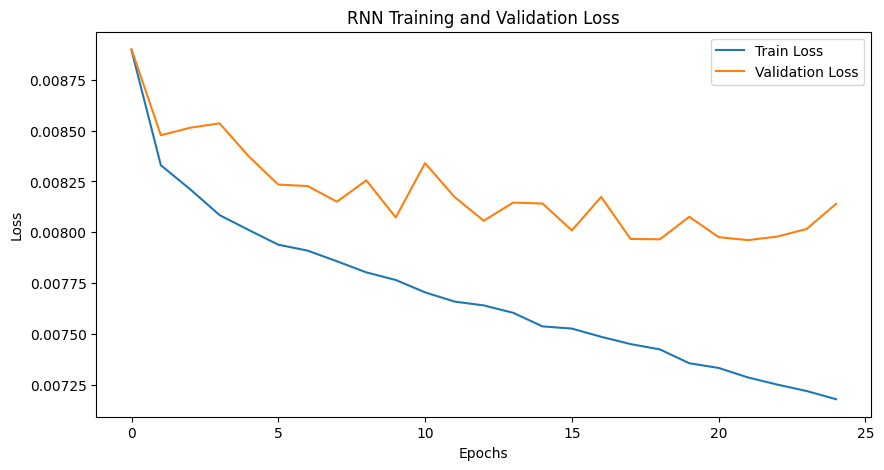

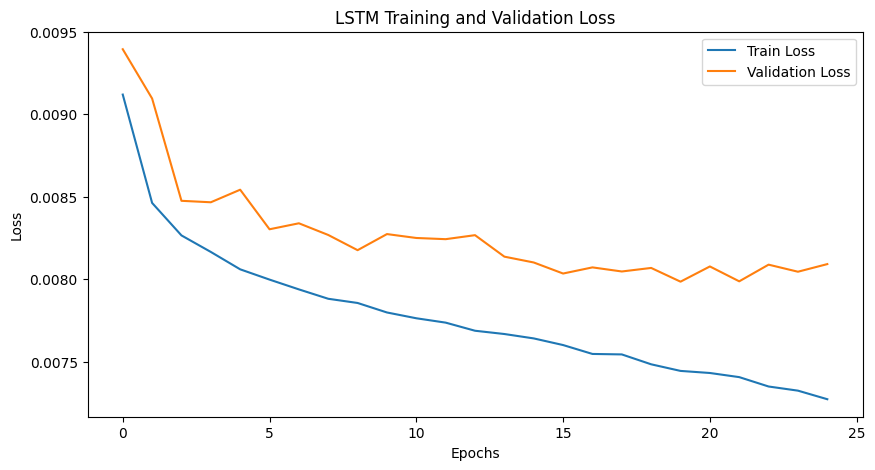

In [ ]:
# Plot training and validation loss
def plot_history(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(rnn_history, 'RNN Training and Validation Loss')
plot_history(lstm_history, 'LSTM Training and Validation Loss')

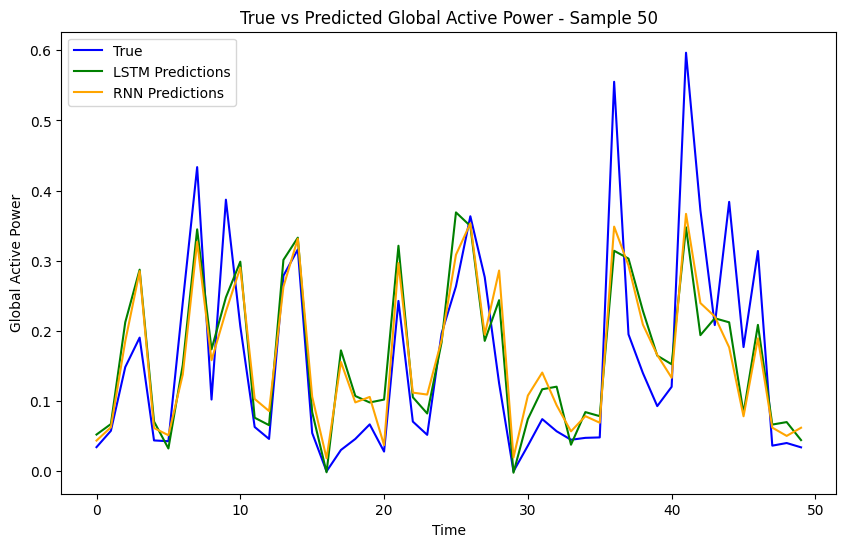

In [ ]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each series on the same axis
ax.plot(y_test[:50], color='blue', label='True')
ax.plot(lstm_predictions[:50], color='green', label='LSTM Predictions')
ax.plot(rnn_predictions[:50], color='orange', label='RNN Predictions')

# Add title and labels
ax.set_title('True vs Predicted Global Active Power - Sample 50')
ax.set_xlabel('Time')
ax.set_ylabel('Global Active Power')

# Add a legend
ax.legend()

# Display the plot
plt.show()

# Conclusion

- Both the RNN and LSTM models show a good ability to capture the general patterns in the `Global Active Power` time series data.
- The RNN model achieves a slightly lower Mean Squared Error (MSE) compared to the LSTM model (0.008158 vs. 0.008340), indicating slightly better performance in this particular case.
- Validation loss plots suggest that while both models generalize reasonably well, the LSTM model exhibits more fluctuations, indicating potential overfitting or sensitivity to validation data.

# Future Enhancements

1. **Hyperparameter Tuning**:
   - Further refine hyperparameters using more extensive search methods such as Bayesian Optimization or Grid Search, in addition to Random Search.
   - Consider tuning additional hyperparameters such as dropout rates, batch size, number of layers, and different optimizers.

2. **Model Complexity**:
   - Experiment with deeper architectures by adding more layers to the RNN and LSTM models.
   - Consider using Bidirectional LSTM or GRU (Gated Recurrent Unit) layers, which might provide better performance by capturing dependencies in both directions.

3. **Feature Engineering**:
   - Introduce additional features that could improve the model's performance, such as lagged values, rolling statistics (mean, variance), or external variables like weather data if relevant.
   - Conduct feature selection to identify the most influential features and reduce dimensionality.

4. **Advanced Models**:
   - Experiment with more advanced architectures such as Transformer models, which have shown great success in capturing long-range dependencies in time series data.
   - Consider using hybrid models that combine the strengths of different neural network types, such as CNN-RNN or CNN-LSTM architectures.

5. **Seasonal Decomposition**:
   - Use seasonal decomposition methods to separately model trend, seasonality, and residuals, and then combine the predictions to improve accuracy.

# References

- [A simple RNN architecture](https://www.researchgate.net/figure/A-simple-RNN-architecture-unrolling_fig5_349025949)
- [A typical architecture of a long short term memory LSTM](https://www.researchgate.net/figure/A-typical-architecture-of-a-long-short-term-memory-LSTM-cell-An-LSTM-block-typically_fig1_344213150)
-[Multivariate Time Series Analysis with Deep Learning, Rui Goncalves (March 2021)](https://repositorio-aberto.up.pt/bitstream/10216/135947/2/492480.pdf)
-[LONG SHORT-TERM MEMORY](https://www.bioinf.jku.at/publications/older/2604.pdf)
-[Understanding LSTM Networks, Posted on August 27, 2015](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
-[Sequence Modeling: Recurrent and Recursive Nets](https://www.deeplearningbook.org/contents/rnn.html)
-[Convolutional Networks](https://www.deeplearningbook.org/contents/convnets.html)
-[A Survey of Deep Learning and Foundation Models for Time Series Forecasting, 2024](https://arxiv.org/pdf/2401.13912)
-[Time series forecasting - TensorFlow](https://www.tensorflow.org/tutorials/structured_data/time_series#baselines)
-[Advances in Deep Learning for Time Series Forecasting/Classification Winter 2024](https://medium.com/deep-data-science/advances-in-deep-learning-for-time-series-forecasting-classification-winter-2024-a3fd31b875b0)
-[Attention for time series forecasting and classification](https://towardsdatascience.com/attention-for-time-series-classification-and-forecasting-261723e0006d)
-[Time Series Analysis: Definition, Types, Techniques, and When It's Used](https://www.tableau.com/learn/articles/time-series-analysis)